# Learning tasks - RobotArm

# Overall analysis 

In [67]:
import pandas as pd 
from distances import preprocess, euclidean_v2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

import ast

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

L1 = "P1M120"
L2 = "P1M123"
L3 = "P1M124"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == L2]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
key_vector_l2 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
key_vector_l3 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"

initial_worldspace_l1 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_worldspace_l2 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"
initial_worldspace_l3 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

#################################### TO CHANGE ! ######################################################

folder = "plots_version2/plot_l3"

robotarm = robotarm_df[robotarm_df['Activity ID'] == L3]

initial_worldspace = initial_worldspace_l3
key_vector = key_vector_l3

penalties = {'move1': 0.1, 'move2': 0.1, 'pickup1': 0.1, 'place1': 0.1}

initial_distance = euclidean_v2(initial_worldspace, key_vector, 0, 0, 0, 0, 0, penalties)

Count : 5


In [70]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1188


### Cleaning the data

In [71]:
# remove rows where there is NaN value in the WorldSpace column
robotarm = robotarm.dropna(subset=['WorldSpace'])

print(f"Number of rows after filtering the NaN values: {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after filtering the NaN values: 983
Number of rows removed: 205
Percentage of rows removed: 17.255892255892256%


In [72]:
# remove the rows where the WorldSpace contains "trial"
robotarm = robotarm[~robotarm['WorldSpace'].str.contains("trial")]

print(f"Number of rows after removing 'trial' (non-consistent worldspace): {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing 'trial' (non-consistent worldspace): 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


It may be the case that when data was collected, there was errors. 
One thing that I noticed is that in some cases, we have more elements than we should have, i.e. for the learning task 1, we should have a maximum of 2 As. If we have more, or also any B element, that means that the worldspace is not correct for the task, so the line should be removed in that case. 

In [73]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

In [74]:
robotarm['longer_worldspace'] = robotarm.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['longer_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['longer_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [75]:
robotarm['missing_worldspace'] = robotarm.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['missing_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['missing_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [76]:
print(f"Number of rows after filtering: {robotarm.shape[0]}")
print(f"Number of rows removed from filtering the initial dataset: {initial_length - robotarm.shape[0]}")
print(f"Percentage of rows removed from filtering the initial dataset: {100*(initial_length - robotarm.shape[0])/initial_length}%")

Number of rows after filtering: 983
Number of rows removed from filtering the initial dataset: 205
Percentage of rows removed from filtering the initial dataset: 17.255892255892256%


Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [77]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [78]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Selecting only useful informations

In [79]:
data = robotarm[["Student ID", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

### Adding initial vector as starting point 

In [80]:
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

### Create column corresponding to percentage of activity completed

In [81]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

In [82]:
data['pct_activity'] = data['index'] / data['nb_tentative']

In [83]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 228


### Create column to indicate if the student made an error or not during the tentative

In [84]:
def detect_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return int(matrix[-1][-1] != 'false')

In [85]:
def detect_type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0

In [86]:
def detect_missing_element(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
        
    error = initial_count_A != goal_count_A or initial_count_B != goal_count_B
    
    return int(error)

In [87]:
data['error'] = data['WorldSpace'].apply(lambda x: detect_error(x))

In [88]:
data['missing'] = data['WorldSpace'].apply(lambda x: detect_missing_element(x, key_vector))

In [89]:
for error in ['move1', 'move2', 'pickup1', 'place1']:
    data[error] = data['WorldSpace'].apply(lambda x: detect_type_error(x, error))

In [90]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f"nb_{x}"] = data.groupby('Student ID')[x].transform('sum')

### Add percentage columns 

In [91]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f'pct_{x}'] = data[f'nb_{x}'] / data['nb_tentative']

### Compute euclidean distance

In [92]:
for idx, row in data.iterrows():
    missing = row['missing']
    move1 = row['move1']
    move2 = row['move2']
    pickup1 = row['pickup1']
    place1 = row['place1']
    
    data.loc[idx, 'euclidean_distance'] = euclidean_v2(row['WorldSpace'], key_vector, move1, move2, 
                                                        place1, pickup1, missing, penalties)

Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 4
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 4
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5


### Separate the successful and failing students

In [93]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  228
Number of students who succeeded:  110
Number of students who failed:  118


In [94]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

In [95]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max', 
                                                           'nb_error': 'max', 'nb_move1': 'max', 'nb_move2': 'max', 
                                                           'nb_pickup1': 'max', 'nb_place1': 'max', 'pct_error': 'max', 
                                                           'pct_move1': 'max', 'pct_move2': 'max', 'pct_pickup1': 'max', 
                                                           'pct_place1': 'max'})
data_grouped_per_student.columns = ['mean_euclidean_distance', 'nb_tentative', 'nb_error', 'nb_move1', 
                                    'nb_move2', 'nb_pickup1', 'nb_place1', 'pct_error', 'pct_move1', 
                                    'pct_move2', 'pct_pickup1', 'pct_place1']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

In [96]:
# sum of the column error over the length of the dataset
pct_error_success = data_success['error'].sum() / len(data_success)
pct_error_fail = data_fail['error'].sum() / len(data_fail)
pct_error_tot = data['error'].sum() / len(data)

print(f"Percentage of error for all the tentatives in successful students dataset: {pct_error_success:.2f}")
print(f"Percentage of error for all the tentatives in failing students dataset: {pct_error_fail:.2f}")
print(f"Percentage of error for all the tentatives in the whole dataset: {pct_error_tot:.2f}")

Percentage of error for all the tentatives in successful students dataset: 0.13
Percentage of error for all the tentatives in failing students dataset: 0.18
Percentage of error for all the tentatives in the whole dataset: 0.15


# Analysis 

In [97]:
data[['index', 'nb_tentative', 'euclidean_distance', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,pct_activity
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,2.893476,5.786953,0.141070,0.500000
std,2.750997,3.380674,0.076219,0.355281
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,0.114016,0.200000
50%,2.000000,5.000000,0.145250,0.500000
75%,4.000000,8.000000,0.189423,0.800000
max,18.000000,18.000000,0.275267,1.000000


In [98]:
data_success[['index', 'nb_tentative', 'euclidean_distance', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,pct_activity
count,652.000000,652.000000,652.000000,652.00000
mean,3.007669,6.015337,0.118822,0.50000
std,2.617137,2.911349,0.083027,0.34485
min,0.000000,1.000000,0.000000,0.00000
25%,1.000000,4.000000,0.044173,0.20000
50%,2.000000,5.000000,0.129633,0.50000
75%,4.000000,8.000000,0.145250,0.80000
max,13.000000,13.000000,0.252098,1.00000


In [99]:
data_grouped_per_student_success.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.0
mean,0.120388,4.927273,0.763636,0.281818,0.009091,0.118182,0.354545,0.129526,0.046910,0.001299,0.021364,0.059953,1.0
std,0.016742,2.551161,1.312797,0.731115,0.095346,0.351454,0.785025,0.195245,0.109022,0.013621,0.065791,0.138665,0.0
min,0.088311,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.110380,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.119020,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.132449,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.216667,0.000000,0.000000,0.000000,0.000000,1.0
max,0.175051,13.000000,7.000000,4.000000,1.000000,2.000000,4.000000,0.666667,0.500000,0.142857,0.333333,0.666667,1.0


In [100]:
data_fail[['index', 'nb_tentative', 'euclidean_distance', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,pct_activity
count,559.000000,559.000000,559.000000,559.000000
mean,2.760286,5.520572,0.167019,0.500000
std,2.896011,3.842209,0.057462,0.367384
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,0.145250,0.166667
50%,2.000000,5.000000,0.145250,0.500000
75%,4.000000,7.000000,0.223337,0.833333
max,18.000000,18.000000,0.275267,1.000000


In [101]:
data_grouped_per_student_fail.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.0
mean,0.176065,3.737288,0.872881,0.211864,0.008475,0.101695,0.550847,0.172451,0.041042,0.002119,0.017491,0.111799,0.0
std,0.027848,2.918927,1.374658,0.536715,0.092057,0.400637,1.058926,0.257217,0.103521,0.023014,0.068425,0.208499,0.0
min,0.103482,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.159294,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.180866,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.198674,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.267045,0.000000,0.000000,0.000000,0.160714,0.0
max,0.236770,18.000000,6.000000,3.000000,1.000000,3.000000,5.000000,1.000000,0.500000,0.250000,0.500000,0.833333,0.0


In [102]:
data_grouped_per_student.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,0.149203,4.311404,0.820175,0.245614,0.008772,0.109649,0.456140,0.151741,0.043873,0.001723,0.019359,0.086786,0.482456
std,0.036218,2.805666,1.343326,0.637470,0.093452,0.376974,0.939963,0.229928,0.106016,0.019033,0.067048,0.179759,0.500792
min,0.088311,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.116798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.142283,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.180866,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.064394,1.000000
max,0.236770,18.000000,7.000000,4.000000,1.000000,3.000000,5.000000,1.000000,0.500000,0.250000,0.500000,0.833333,1.000000


### Euclidean distance

Sanity check !

In [103]:
data[data['euclidean_distance'] == 0]

,Student ID,WorldSpace,index,nb_tentative,pct_activity,error,missing,move1,move2,pickup1,...,nb_pickup1,nb_place1,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,euclidean_distance,success
8,AUS123109,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,3,1.0,0,0,0,0,0,...,0,2,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.0,1
23,AUS123505,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",11,11,1.0,0,0,0,0,0,...,0,1,0.454545,0.272727,0.363636,0.0,0.0,0.090909,0.0,1
41,AUS123613,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,4,1.0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1
49,AUS123757,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,2,1.0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1
57,AUS123837,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",5,5,1.0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,NOR914213,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",6,6,1.0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1
1182,NOR914249,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,2,1.0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1
1198,UK123010,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",5,5,1.0,0,0,0,0,0,...,0,1,0.200000,0.000000,0.000000,0.0,0.0,0.200000,0.0,1
1204,UK123019,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,3,1.0,0,0,0,0,0,...,0,0,0.333333,0.000000,0.333333,0.0,0.0,0.000000,0.0,1


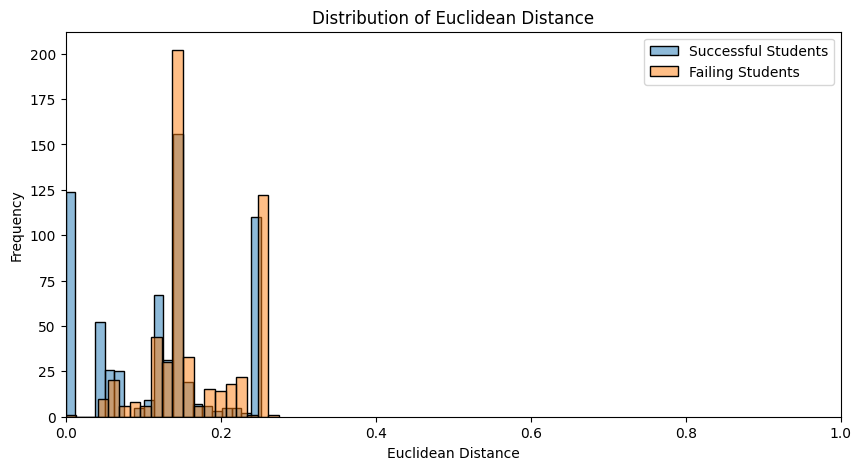

In [104]:
plt.figure(figsize=(10, 5))
sns.histplot(data_success['euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_fail['euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance.png")

plt.show()

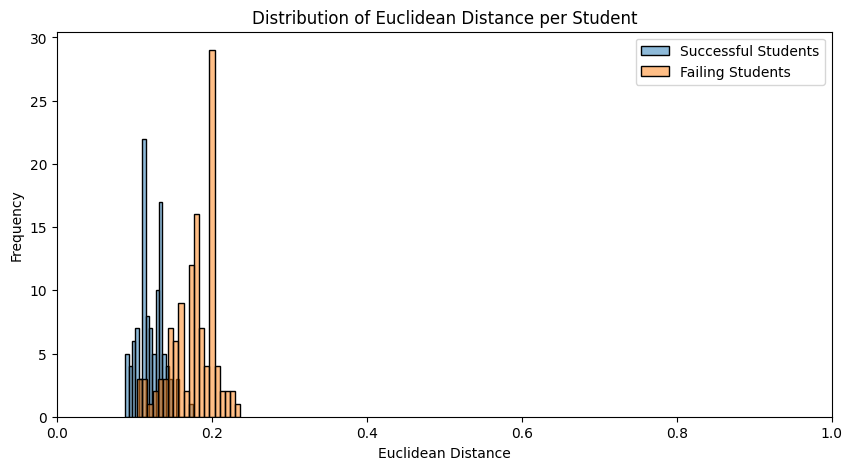

In [105]:
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['mean_euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['mean_euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance per Student')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_per_student.png")

plt.show()

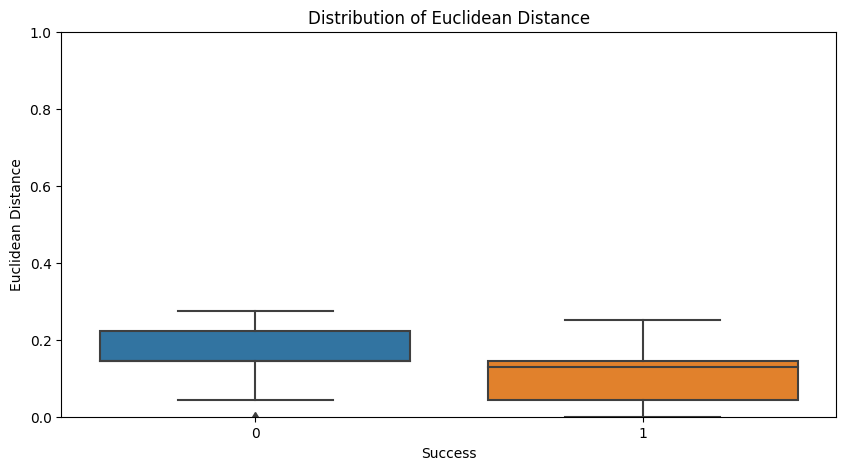

In [106]:
# Create box plots for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='euclidean_distance', data=data)
plt.ylim(0, 1)
plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance')
plt.savefig(f"{folder}/boxplot_euclidean_distance.png")

plt.show()


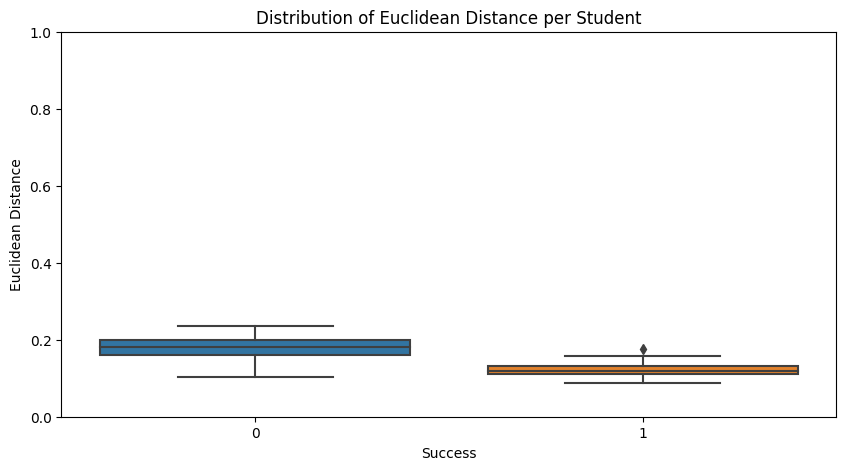

In [107]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='mean_euclidean_distance', data=data_grouped_per_student)
plt.ylim(0, 1)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance per Student')

plt.savefig(f"{folder}/boxplot_euclidean_distance_per_student.png")

plt.show()

In [108]:
# Assuming 'euclidean_distance_successful' and 'euclidean_distance_failing' are arrays of Euclidean distances
statistic, p_value = mannwhitneyu(data_success['euclidean_distance'], data_fail['euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of Euclidean distance (p >= 0.05)")
    


There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)


### Number of tentatives/runs

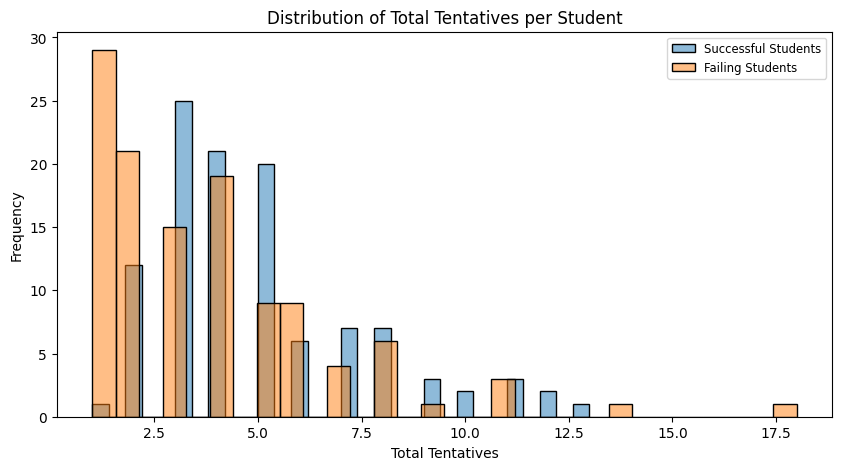

In [109]:
# Create histograms for the number of tentatives
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['nb_tentative'], bins=30, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['nb_tentative'], bins=30, label='Failing Students', alpha=0.5)
plt.xlabel('Total Tentatives')
plt.ylabel('Frequency')
plt.title('Distribution of Total Tentatives per Student')
plt.legend(fontsize='small')
plt.show()

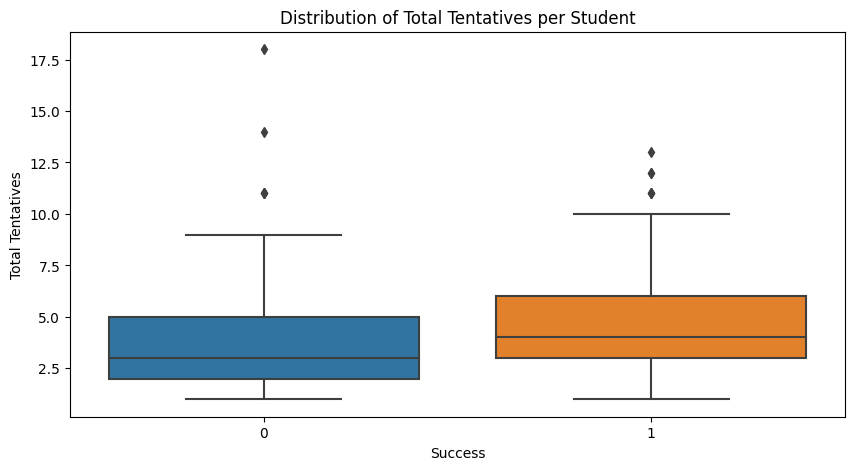

In [110]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student.png")
plt.show()

In [111]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)


### Observe the number of errors per students 

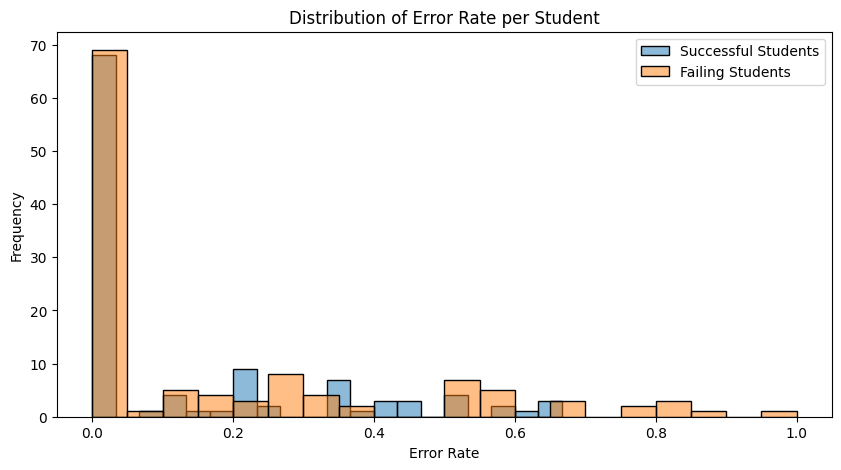

In [112]:
# plot distribution of percentage of error
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()

plt.savefig(f"{folder}/error_rate_per_student.png")
plt.show()

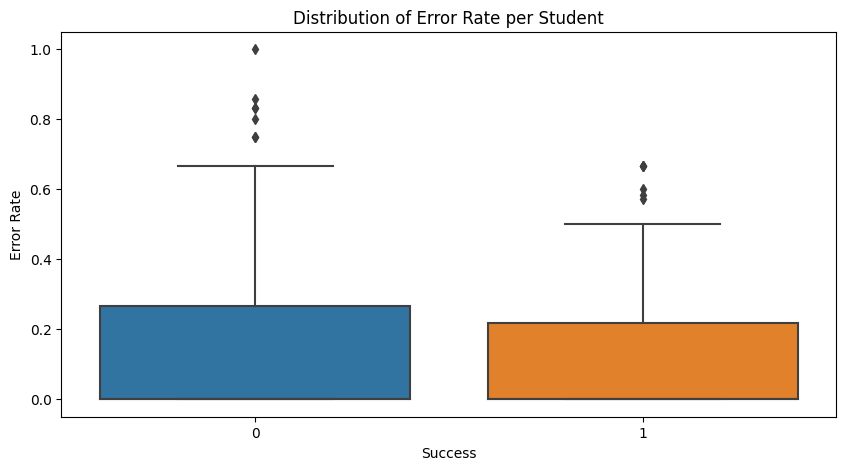

In [113]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='pct_error', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.title('Distribution of Error Rate per Student')

plt.savefig(f"{folder}/boxplot_error_rate_per_student.png")
plt.show()

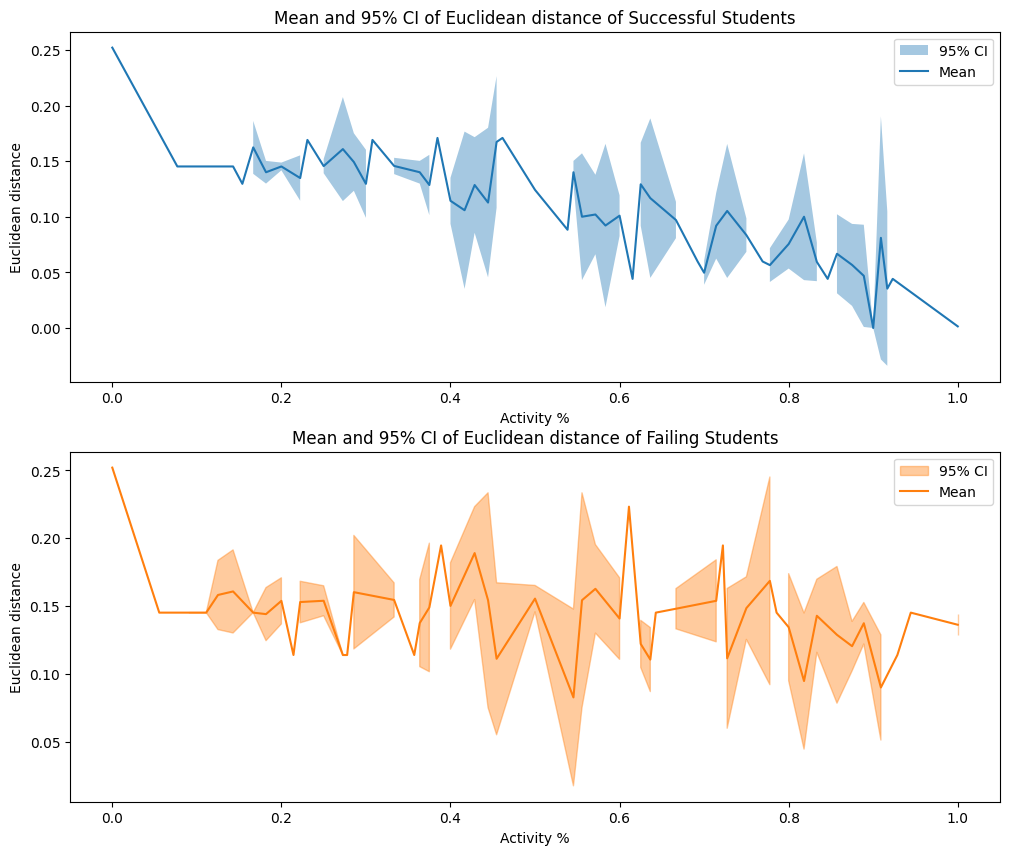

In [114]:
# plot one figure
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

grouped_success = data_success.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_success = grouped_success["euclidean_distance"].mean()
ci_values_bars_success = grouped_success["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[0].fill_between(mean_values_bars_success.index, mean_values_bars_success - ci_values_bars_success, mean_values_bars_success + ci_values_bars_success, alpha=0.4, label="95% CI")

ax[0].plot(mean_values_bars_success.index, mean_values_bars_success, linestyle='-', label="Mean")
#ax[0].set_ylim(-0.1, 1)
ax[0].set_xlabel("Activity %")
ax[0].set_ylabel("Euclidean distance")
ax[0].set_title("Mean and 95% CI of Euclidean distance of Successful Students")
ax[0].legend()

grouped_fail = data_fail.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_fail = grouped_fail["euclidean_distance"].mean()
ci_values_bars_fail = grouped_fail["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[1].fill_between(mean_values_bars_fail.index, mean_values_bars_fail - ci_values_bars_fail, mean_values_bars_fail + ci_values_bars_fail, alpha=0.4, color= '#ff7f0e', label="95% CI")

ax[1].plot(mean_values_bars_fail.index, mean_values_bars_fail, linestyle='-', color= '#ff7f0e', label="Mean")
#ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel("Activity %")
ax[1].set_ylabel("Euclidean distance")
ax[1].set_title("Mean and 95% CI of Euclidean distance of Failing Students")
ax[1].legend()

plt.show()

In [115]:
data_success_filtered = data_success[data_success['nb_tentative'] <= 10]
data_fail_filtered = data_fail[data_fail['nb_tentative'] <= 10]

nb_student_success_filtered = len(data_success_filtered['Student ID'].unique())
nb_student_fail_filtered = len(data_fail_filtered['Student ID'].unique())

print(f"Number of successful students after filtering: {nb_student_success_filtered}")
print(f"Number of failing students after filtering: {nb_student_fail_filtered}")

print(f"Number of rows in successful students dataset after filtering: {data_success_filtered.shape[0]}")
print(f"Number of rows in failing students dataset after filtering: {data_fail_filtered.shape[0]}")

Number of successful students after filtering: 104
Number of failing students after filtering: 113
Number of rows in successful students dataset after filtering: 576
Number of rows in failing students dataset after filtering: 489


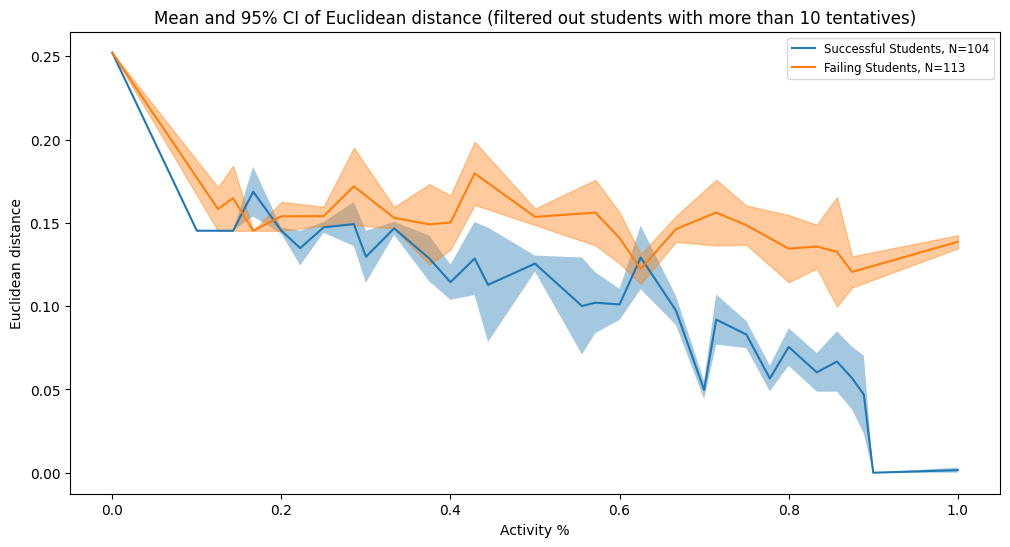

In [116]:
grouped_success = data_success_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_success = grouped_success.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_success['ci_value'] = grouped_success["euclidean_distance_sem"] * 1.96

grouped_fail = data_fail_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_fail = grouped_fail.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_fail['ci_value'] = grouped_fail["euclidean_distance_sem"] * 1.96


# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', label=f"Successful Students, N={nb_student_success_filtered}")

ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.4)
ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', label=f"Failing Students, N={nb_student_fail_filtered}")

# Set labels and title
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distance (filtered out students with more than 10 tentatives)")
ax.legend(fontsize='small')
#plt.ylim(-0.05, 1)

plt.savefig(f'{folder}/euclidean_dist_act_pct.png')
plt.show()

In [117]:
data_success_per_nb_tentative = data_success.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                          'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                          'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_success_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

data_fail_per_nb_tentative = data_fail.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                    'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                    'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_fail_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

# fill the NaN values with 0
data_success_per_nb_tentative = data_success_per_nb_tentative.fillna(0)
data_fail_per_nb_tentative = data_fail_per_nb_tentative.fillna(0)

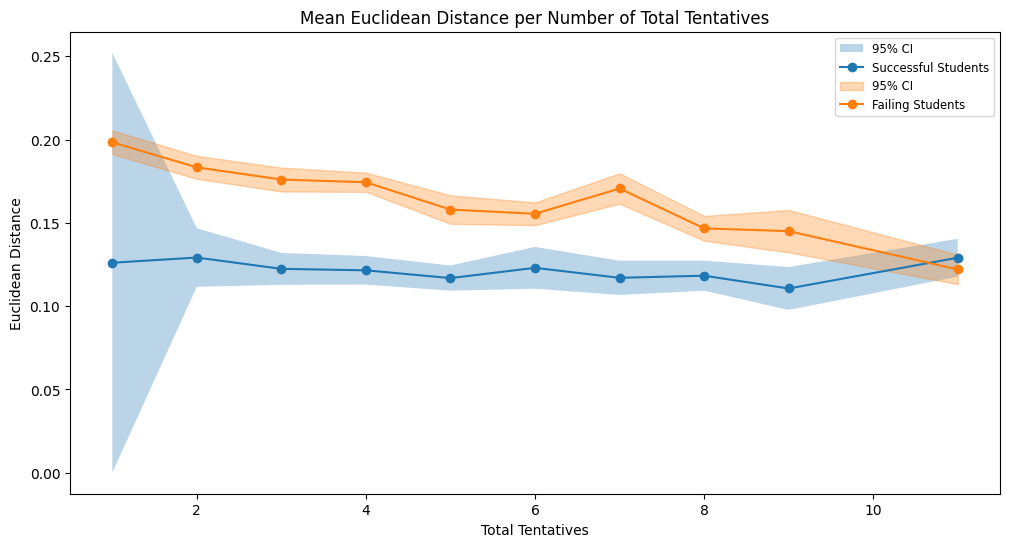

In [118]:
nb_tentative_success = data_success_per_nb_tentative.index.to_list()
nb_tentative_fail = data_fail_per_nb_tentative.index.to_list()

nb_tentative_index = set(nb_tentative_success).intersection(set(nb_tentative_fail))

data_success_per_nb_tentative = data_success_per_nb_tentative[data_success_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()
data_fail_per_nb_tentative = data_fail_per_nb_tentative[data_fail_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()

# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'] - data_success_per_nb_tentative['euclidean_distance_sem'], 
                data_success_per_nb_tentative["euclidean_distance_mean"] + data_success_per_nb_tentative['euclidean_distance_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'] - data_fail_per_nb_tentative['euclidean_distance_sem'], 
                data_fail_per_nb_tentative["euclidean_distance_mean"] + data_fail_per_nb_tentative['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Mean Euclidean Distance per Number of Total Tentatives')
ax.legend(fontsize='small')
#plt.ylim(0, 1)

plt.savefig(f"{folder}/mean_euclidean_distance_per_nb_tentative.png")

plt.show()

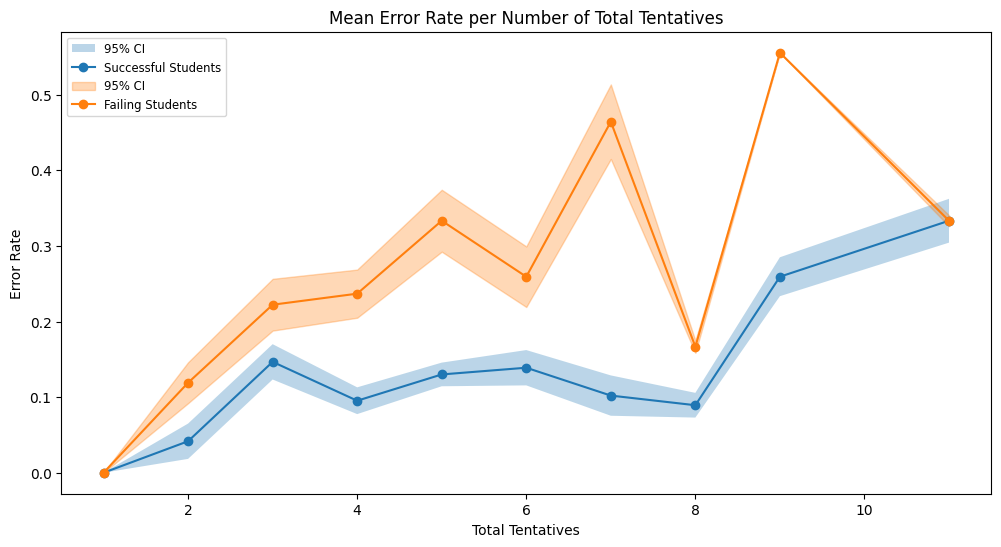

In [119]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'] - data_success_per_nb_tentative['pct_error_sem'], 
                data_success_per_nb_tentative["pct_error_mean"] + data_success_per_nb_tentative['pct_error_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'] - data_fail_per_nb_tentative['pct_error_sem'], 
                data_fail_per_nb_tentative["pct_error_mean"] + data_fail_per_nb_tentative['pct_error_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Error Rate')
ax.set_title('Mean Error Rate per Number of Total Tentatives')
ax.legend(fontsize='small')
#plt.ylim(-0.1, 1)
plt.savefig(f"{folder}/error_rate_per_nb_tentatives.png")
plt.show()

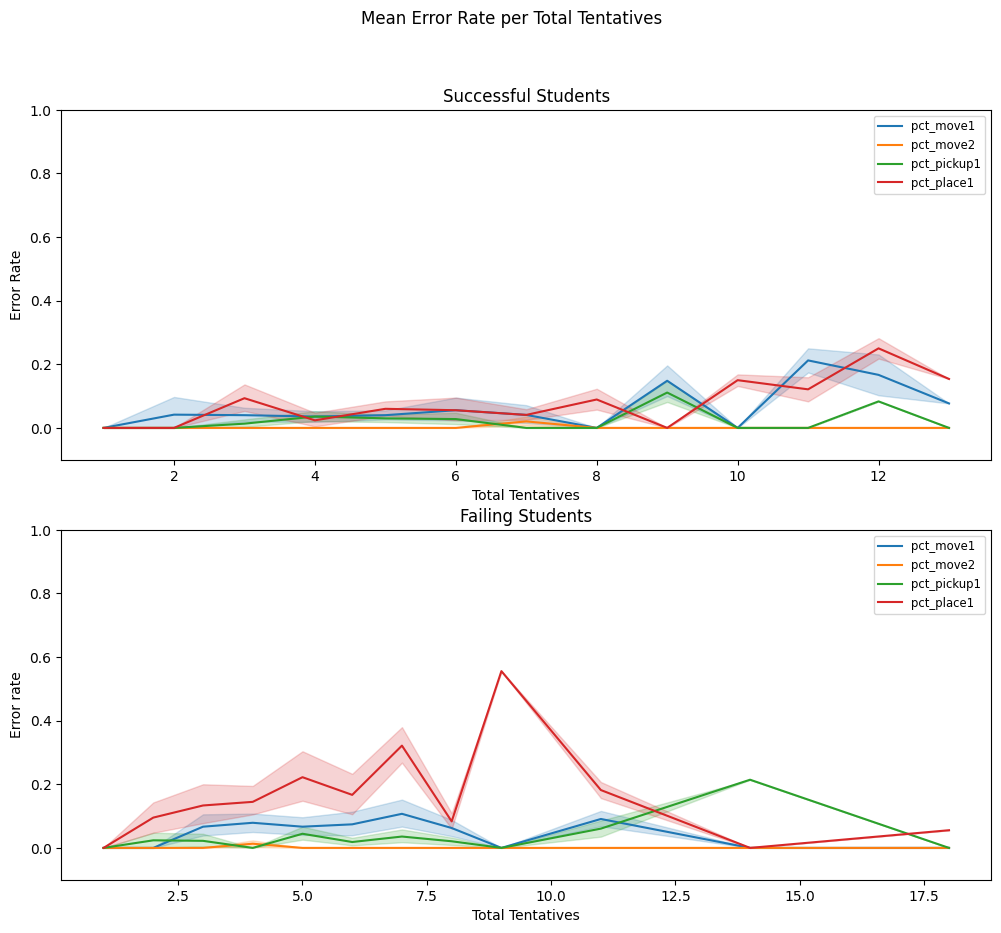

In [120]:
# plot the pct_error_move1, pct_error_move2, pct_error_pickup1, pct_error_pickup2 for Successful Students and Failing Students
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot change in Euclidean distance for successful students
for column in ['pct_move1', 'pct_move2', 'pct_pickup1', 'pct_place1']:
            sns.lineplot(data=data_success, y=column, x='nb_tentative', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax[0], label=column)

ax[0].set_ylim(-0.1, 1)
ax[0].set_xlabel('Total Tentatives')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Successful Students')
ax[0].legend(fontsize='small')

# Plot change in Euclidean distance for failing students
for column in ['pct_move1', 'pct_move2', 'pct_pickup1', 'pct_place1']:
            sns.lineplot(data=data_fail, y=column, x='nb_tentative', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax[1], label=column)
            
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel('Total Tentatives')
ax[1].set_ylabel('Error rate')
ax[1].set_title('Failing Students')
ax[1].legend(fontsize='small')


plt.suptitle("Mean Error Rate per Total Tentatives")
plt.savefig(f"{folder}/type_error_rate_per_tentative.png")
plt.show()

### Analysis of behaviors by grouping students by the number of tentatives

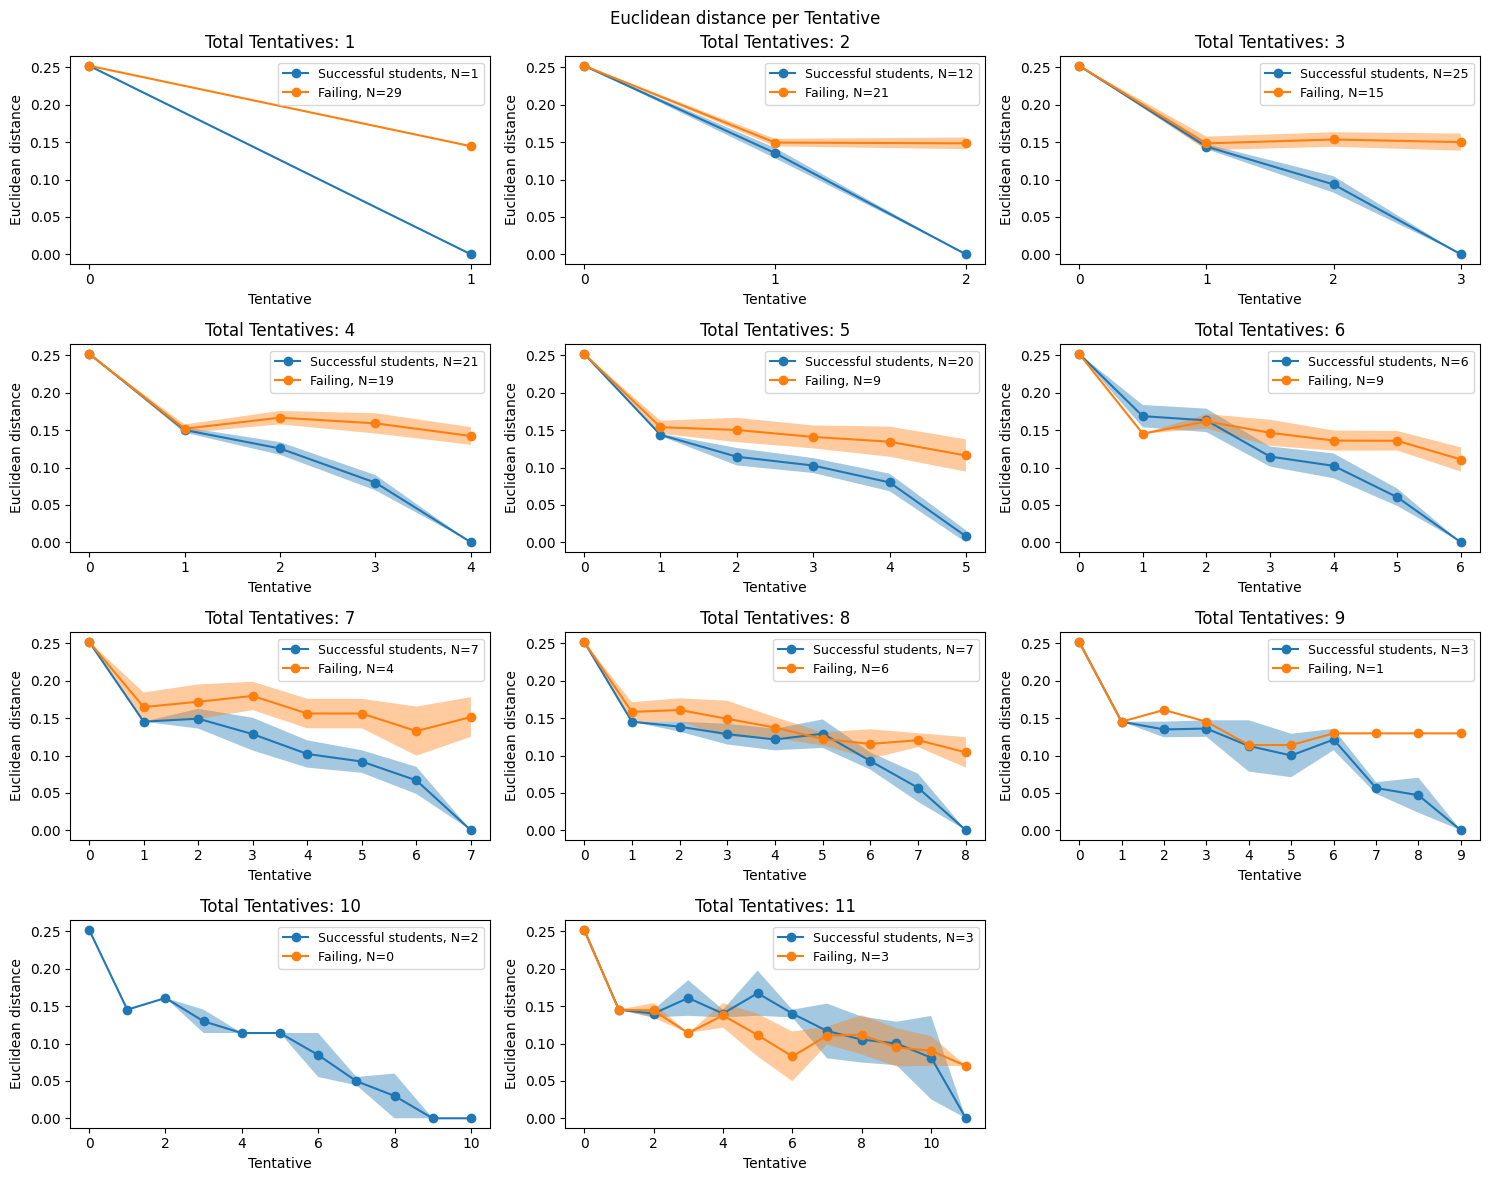

In [121]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['euclidean_distance_sem'].fillna(0, inplace=True)

        grouped_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['euclidean_distance_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Successful students, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        #ax.set_ylim(0, 0.8)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.legend(loc='upper right', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance per Tentative")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_per_tentative_multi.png")
plt.show()

In [122]:
# for each students, check what is the euclidean distance for the last tentative
data_tentative_7 = data_success[data_success['nb_tentative'] == 7]
data_last_tentative = data_tentative_7[data_tentative_7['index'] == data_tentative_7['nb_tentative']]
data_last_tentative[data_last_tentative['euclidean_distance'] != 0]


,Student ID,WorldSpace,index,nb_tentative,pct_activity,error,missing,move1,move2,pickup1,...,nb_pickup1,nb_place1,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,euclidean_distance,success


# Analysis of the difference between the successive runs

In [123]:
data_success_deltas = data_success[['Student ID', 'nb_tentative', 'index', 'error', 'pct_activity']]
data_failing_deltas = data_fail[['Student ID', 'nb_tentative', 'index', 'error', 'pct_activity']]

# group by Student ID and sort by index
data_success_deltas = data_success_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)
data_failing_deltas = data_failing_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

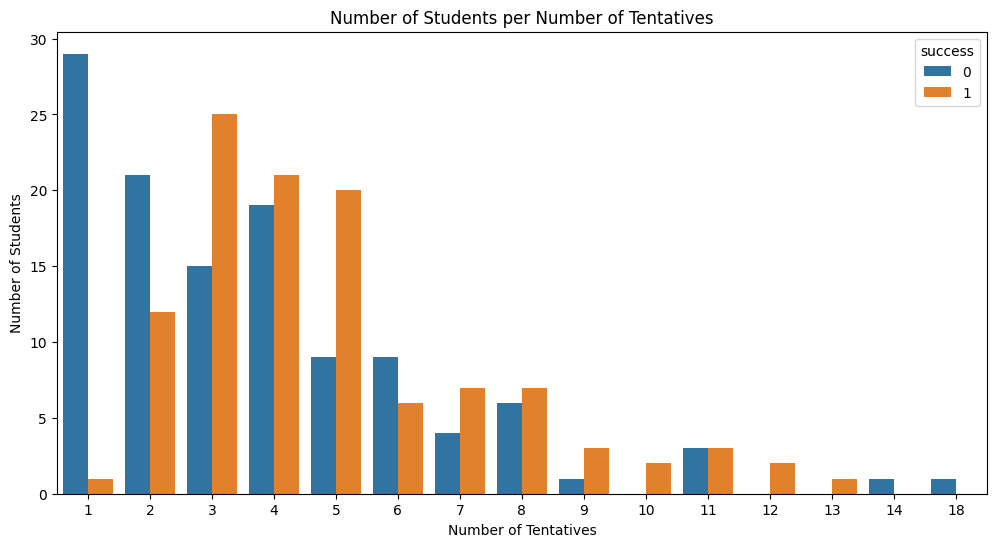

In [124]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives.png')
plt.show()

## Evalutation of the difference between successive runs 

### Descriptive analysis 

In [125]:
data_success_deltas.describe()

,nb_tentative,index,error,pct_activity
count,652.000000,652.000000,652.000000,652.00000
mean,6.015337,3.007669,0.128834,0.50000
std,2.911349,2.617137,0.335274,0.34485
min,1.000000,0.000000,0.000000,0.00000
25%,4.000000,1.000000,0.000000,0.20000
50%,5.000000,2.000000,0.000000,0.50000
75%,8.000000,4.000000,0.000000,0.80000
max,13.000000,13.000000,1.000000,1.00000


In [126]:
data_failing_deltas.describe()

,nb_tentative,index,error,pct_activity
count,559.000000,559.000000,559.000000,559.000000
mean,5.520572,2.760286,0.184258,0.500000
std,3.842209,2.896011,0.388041,0.367384
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.166667
50%,5.000000,2.000000,0.000000,0.500000
75%,7.000000,4.000000,0.000000,0.833333
max,18.000000,18.000000,1.000000,1.000000


Different type of errors: 
* move1 : cannot move, claw hit a wall 
* move 2 : collision, objects are stacked to high
* pickup1 : cannot pick up, claw is already holding an object 
* pickup2 : cannot place, claw is not holding any objet 

Should we differentiate the errors by giving a different penalty ? 

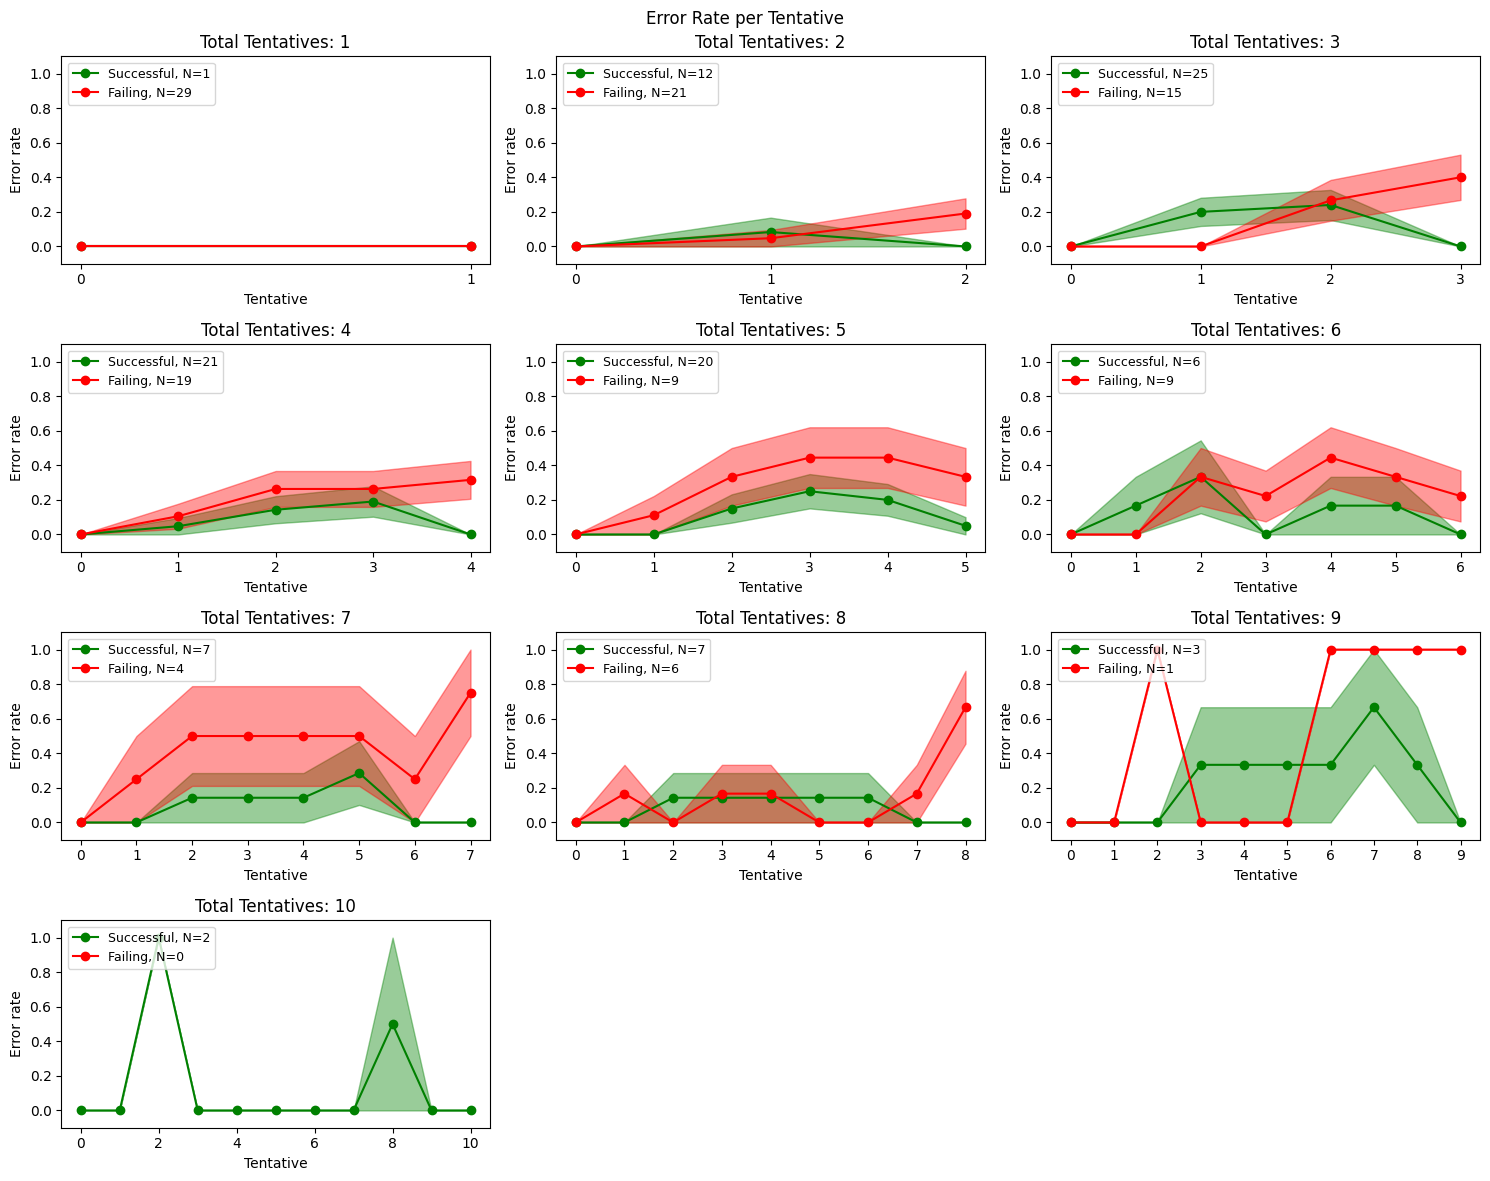

In [127]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success_deltas[data_success_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_success.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['error_sem'].fillna(0, inplace=True)

        grouped_fail = data_failing_deltas[data_failing_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_fail.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['error_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['error_mean'] - grouped_success['error_sem'], grouped_success["error_mean"] + grouped_success['error_sem'], alpha=0.4, color="green")
        ax.plot(grouped_success.index, grouped_success['error_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}", color="green")
        
        ax.fill_between(grouped_fail.index, grouped_fail['error_mean'] - grouped_fail['error_sem'], grouped_fail["error_mean"] + grouped_fail['error_sem'], alpha=0.4, color="red")
        ax.plot(grouped_fail.index, grouped_fail['error_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}", color="red")
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_multi.png')

plt.show()

Anaylsis of the gap between successive values 

In [128]:
for idx, row in data.iterrows(): 
    if row['index'] == 0: 
        data.loc[idx, 'delta_successive'] = 0
    else: 
        data.loc[idx, 'delta_successive'] = euclidean_v2(data.loc[idx, 'WorldSpace'], data.loc[idx-1, 'WorldSpace'], 
                                          data.loc[idx, 'move1'], data.loc[idx, 'move2'], data.loc[idx, 'place1'], 
                                          data.loc[idx, 'pickup1'], data.loc[idx, 'missing'], penalties)

Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 4
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5


In [129]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

In [130]:
# filter out the students with more than 10 tentatives
data_filtered = data[data['nb_tentative'] <= 10]
data_success_filtered = data_success[data_success['nb_tentative'] <= 10]
data_fail_filtered = data_fail[data_fail['nb_tentative'] <= 10]


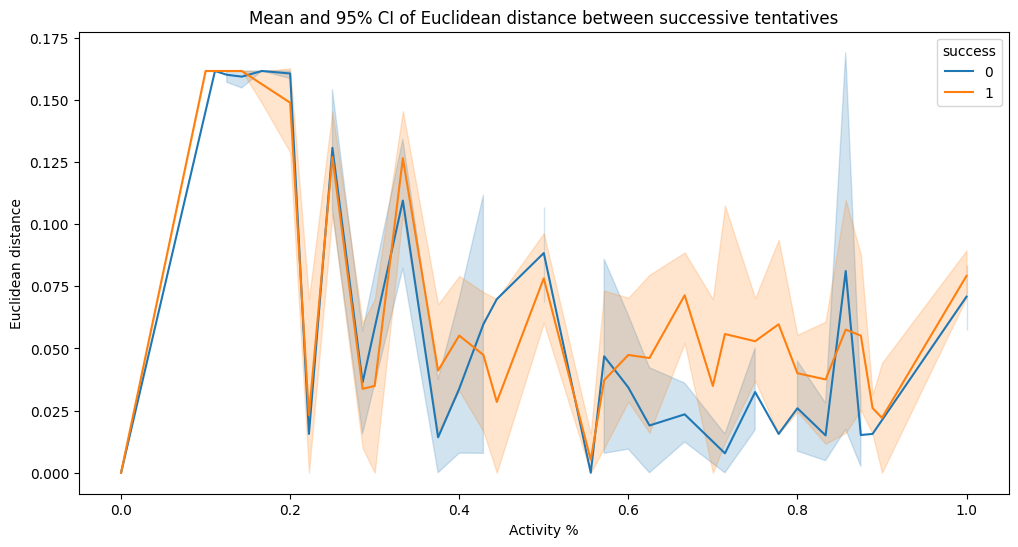

In [131]:
# change size of the figure
plt.figure(figsize=(12, 6))

sns.lineplot(data=data_filtered, y=f'delta_successive', x='pct_activity', hue="success",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95)
plt.xlabel('Activity %')
plt.ylabel('Euclidean distance')
plt.title('Mean and 95% CI of Euclidean distance between successive tentatives')
plt.savefig(f"{folder}/euclidean_distance_pct_successive.png")
plt.show()

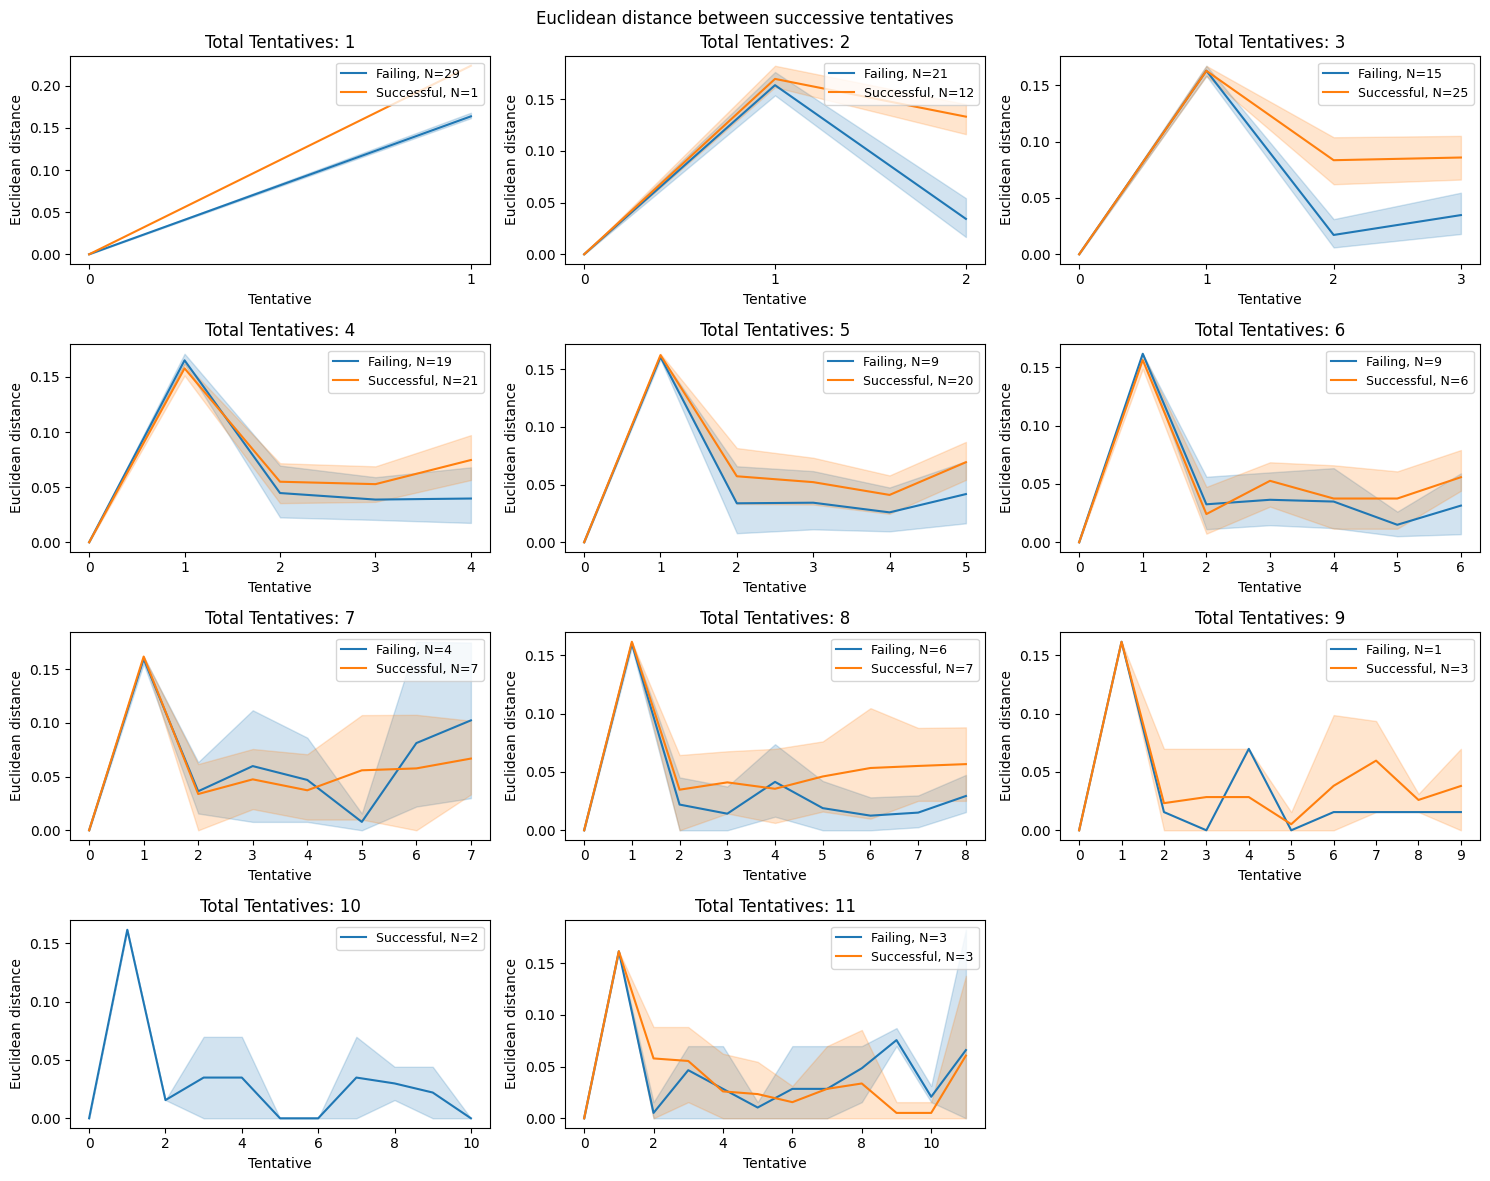

In [132]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
        
        # count number of failing and successful students
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        sns.lineplot(data=grouped_data, y=f'delta_successive', x='index', hue="success",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax, legend=True)
        
        #ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label == '0':
                new_labels.append(f"Failing, N={nb_fail_student}")
            else:
                new_labels.append(f"Successful, N={nb_success_student}")
        ax.legend(handles, new_labels, loc='upper right', fontsize=9)
        
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance between successive tentatives")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_per_tentative_successive_multi.png")
plt.show()

In [133]:
data

,Student ID,WorldSpace,index,nb_tentative,pct_activity,error,missing,move1,move2,pickup1,...,nb_place1,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,euclidean_distance,success,delta_successive
5,AUS123109,"['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,...",0,3,0.000000,0,0,0,0,0,...,2,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.252098,1,0.000000
6,AUS123109,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",1,3,0.333333,1,0,0,0,0,...,2,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.160868,1,0.136296
7,AUS123109,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,3,0.666667,1,0,0,0,0,...,2,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.160868,1,0.103963
8,AUS123109,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,3,1.000000,0,0,0,0,0,...,2,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.000000,1,0.145250
12,AUS123505,"['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,...",0,11,0.000000,0,0,0,0,0,...,1,0.454545,0.272727,0.363636,0.0,0.0,0.090909,0.252098,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,UK123022,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",1,5,0.200000,0,0,0,0,0,...,0,0.200000,0.200000,0.000000,0.0,0.2,0.000000,0.145250,0,0.161651
1207,UK123022,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,5,0.400000,0,0,0,0,0,...,0,0.200000,0.200000,0.000000,0.0,0.2,0.000000,0.145250,0,0.000000
1208,UK123022,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,5,0.600000,0,0,0,0,0,...,0,0.200000,0.200000,0.000000,0.0,0.2,0.000000,0.145250,0,0.000000
1209,UK123022,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,5,0.800000,0,0,0,0,0,...,0,0.200000,0.200000,0.000000,0.0,0.2,0.000000,0.145250,0,0.000000


In [134]:
# compute if there is a correlation between the number of tentatives and the number of errors
correlation = data_grouped_per_student[['nb_tentative', 'nb_error']].corr()

In [135]:
correlation

,nb_tentative,nb_error
nb_tentative,1.000000,0.560774
nb_error,0.560774,1.000000


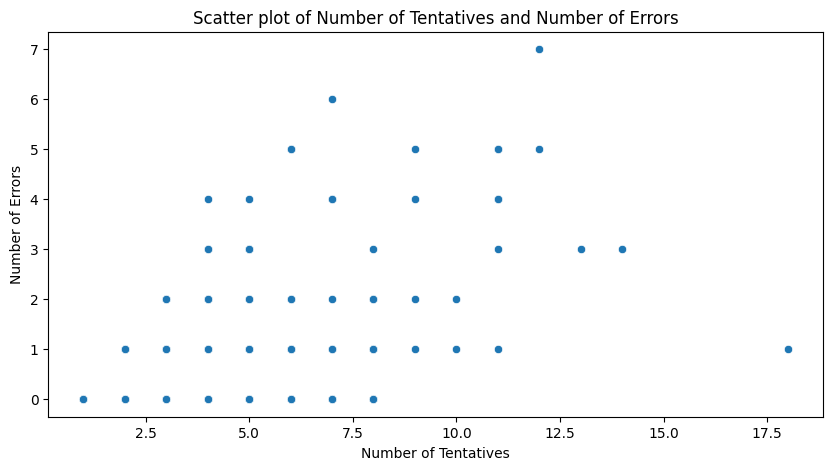

In [138]:
# plot scatter plot of the number of tentatives and the number of errors
plt.figure(figsize=(10, 5))

sns.scatterplot(data=data_grouped_per_student, x='nb_tentative', y='nb_error')
plt.xlabel('Number of Tentatives')
plt.ylabel('Number of Errors')
plt.title('Scatter plot of Number of Tentatives and Number of Errors')
plt.savefig(f"{folder}/scatterplot_tentatives_errors.png")
plt.show()

In [141]:
import scipy.stats as stats


# test statistical significance of the correlation
statistic, p_value = stats.pearsonr(data_grouped_per_student['nb_tentative'], data_grouped_per_student['nb_error'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant correlation between the number of tentatives and the number of errors (p < 0.05)")
else:
    print("There is no significant correlation between the number of tentatives and the number of errors (p >= 0.05)")

There is a significant correlation between the number of tentatives and the number of errors (p < 0.05)


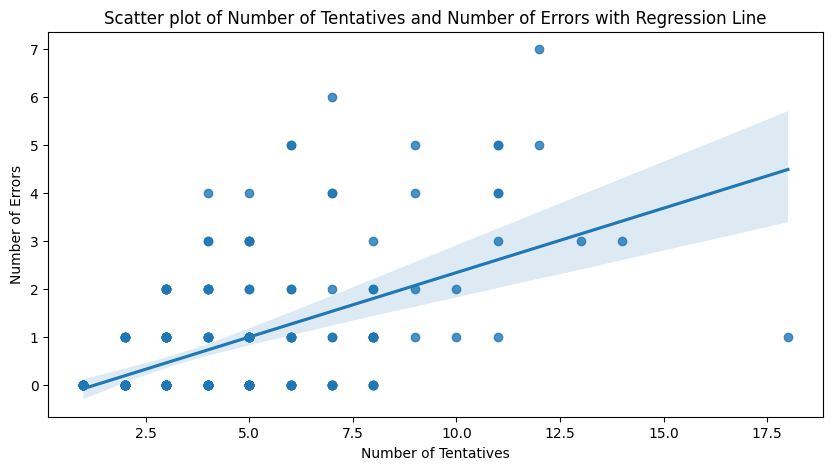

In [142]:
# plot scatter plot of the number of tentatives and the number of errors and a regression line
plt.figure(figsize=(10, 5))

sns.regplot(data=data_grouped_per_student, x='nb_tentative', y='nb_error')
plt.xlabel('Number of Tentatives')
plt.ylabel('Number of Errors')
plt.title('Scatter plot of Number of Tentatives and Number of Errors with Regression Line')
plt.savefig(f"{folder}/scatterplot_tentatives_errors_regression.png")
plt.show()
